# Rede Neural Feedforward com Regularização (Undersampling)
Notebook baseado no original, com etapa modular de regularização do dataset após o carregamento dos dados.

## Importação das bibliotecas
Importe as bibliotecas necessárias para manipulação de dados, modelagem e regularização.

In [1]:
import os
import time
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sklearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Carregamento do dataset
Carregue o dataset de transações simuladas.

In [2]:
# Carregar funções compartilhadas
%run shared_functions.py

# Definir diretório de entrada e datas
DIR_INPUT = 'simulated-data-transformed/data/'
BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Carregando arquivos de transações...")
transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print(f"{len(transactions_df)} transações carregadas, sendo {transactions_df.TX_FRAUD.sum()} fraudes.")

Carregando arquivos de transações...
919767 transações carregadas, sendo 8195 fraudes.


## Regularização do dataset (undersampling modular)
Aplicação modular de regularização para lidar com desbalanceamento. Inicialmente, será usado o RandomUnderSampler.

In [3]:
# Função modular para regularização do dataset
def regularizar_dataset(X, y, metodo='undersampling', sampler=None, **kwargs):
    if metodo == 'undersampling':
        if sampler is None:
            sampler = RandomUnderSampler(**kwargs)
        X_res, y_res = sampler.fit_resample(X, y)
        return X_res, y_res
    # Futuramente: adicionar outros métodos como SMOTE, cost-sensitive, etc.
    else:
        raise NotImplementedError('Método de regularização não implementado.')

# Aplicação do undersampling
input_features = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']
output_feature = 'TX_FRAUD'

X = transactions_df[input_features]
y = transactions_df[output_feature]

X_reg, y_reg = X,y
print(f"Após regularização: {len(X_reg)} amostras, {sum(y_reg)} fraudes.")

Após regularização: 919767 amostras, 8195 fraudes.


## Pré-processamento dos dados
Divida os dados regularizados em treino e teste e realize a normalização.

In [4]:
# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42, stratify=y_reg)

# Normalização (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Conversão dos dados para tensores
Converta os dados normalizados para tensores do PyTorch.

In [5]:
x_train = torch.FloatTensor(X_train_scaled)
x_test = torch.FloatTensor(X_test_scaled)
y_train = torch.FloatTensor(y_train.values) if hasattr(y_train, 'values') else torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test.values) if hasattr(y_test, 'values') else torch.FloatTensor(y_test)

## Definição do Dataset e DataLoader
Crie classes para alimentar o modelo durante o treinamento e avaliação.

In [6]:
class FraudDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

batch_size = 64
train_dataset = FraudDataset(x_train, y_train)
test_dataset = FraudDataset(x_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Definição da arquitetura FraudMLP
Defina a arquitetura da rede neural conforme o notebook original.

In [7]:
class FraudMLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FraudMLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

## Configuração do otimizador e função de perda
Configure o otimizador (Adam) e a função de perda (BCELoss).

In [8]:
input_size = x_train.shape[1]
hidden_size = 1000
model = FraudMLP(input_size, hidden_size)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

## Treinamento do modelo
Treine o modelo utilizando os dados regularizados.

In [ ]:
n_epochs = 50
train_losses = []
test_losses = []
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    train_losses.append(epoch_loss / len(train_loader.dataset))
    # Avaliação no conjunto de teste
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for xb, yb in test_loader:
            preds = model(xb).squeeze()
            loss = criterion(preds, yb)
            test_loss += loss.item() * xb.size(0)
        test_losses.append(test_loss / len(test_loader.dataset))
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}: train loss = {train_losses[-1]:.4f}, test loss = {test_losses[-1]:.4f}")
        

Epoch 10: train loss = 0.0172, test loss = 0.0181
Epoch 20: train loss = 0.0163, test loss = 0.0177
Epoch 30: train loss = 0.0159, test loss = 0.0173
Epoch 40: train loss = 0.0155, test loss = 0.0176
Epoch 50: train loss = 0.0151, test loss = 0.0181


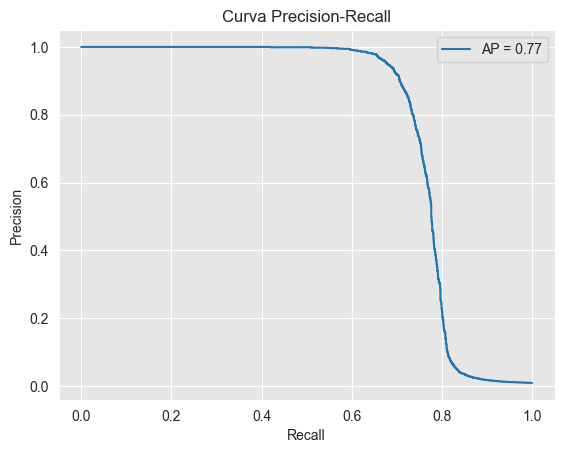

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Após o treinamento, obtenha as probabilidades e rótulos verdadeiros
model.eval()
with torch.no_grad():
    y_scores = model(x_test).squeeze().numpy()
    y_true = y_test.numpy() if hasattr(y_test, 'numpy') else y_test

# Calcule os pontos da curva
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)

# Plote a curva
plt.figure()
plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

## Avaliação do modelo
Avalie o desempenho do modelo com métricas como AUC ROC e precisão.

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score

model.eval()
with torch.no_grad():
    y_pred_proba = model(x_test).squeeze().numpy()
    y_pred = (y_pred_proba > 0.5).astype(int)
auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = sklearn.metrics.f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")
print(f"AUC ROC: {auc:.4f} | Acurácia: {acc:.4f} | Precisão: {prec:.4f}")

Precision (Binary): 0.9178
F1 Score: 0.7939
AUC ROC: 0.9048 | Acurácia: 0.9968 | Precisão: 0.9178


## Visualização das métricas
Plote os gráficos de perda de treino e teste ao longo das épocas.

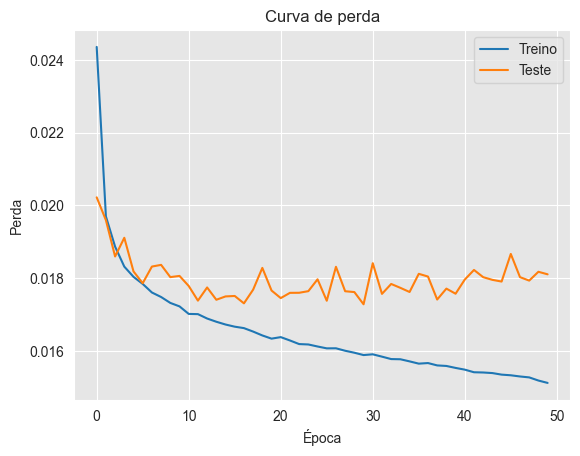

In [11]:
plt.plot(train_losses, label='Treino')
plt.plot(test_losses, label='Teste')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Curva de perda')
plt.legend()
plt.show()